<a href="https://colab.research.google.com/github/Gdushaq/PNN/blob/main/Si_Modulator_Activation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas openpyxl


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   --- ------------------------------------ 0.8/9.7 MB 4.9 MB/s eta 0:00:02
   ------- -------------------------------- 1.8/9.7 MB 5.0 MB/s eta 0:00:02
   ----------- ---------------------------- 2.9/9.7 MB 4.9 MB/s eta 0:00:02
   ---------------- ----------------------- 3.9/9.7 MB 4.8 MB/s eta 0:00:02
   -------------------- ------------------- 5.0/9.7 MB 4.9 MB/s eta 0:00:01
   ------------------------ --------------- 6.0/9.7 MB 5.0 MB/s eta 0:00:01
   ----------------------------- ---------- 7.1/9.7 MB 5.0 MB/s eta 0:00:01
   --------------------------------- ------ 8.1/9.7 MB 5.0 MB/s eta 0:00:01
   -------------------------------------- - 9.4/9.7 MB 5.1 MB/s eta 0:00:01
   ---------------------------------------  9.7/9.7 MB 5.1 MB/s eta 0:00:01
   ---------------------------------------- 9.7/9.7 MB 4.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd

file_path = r"C:\Users\ghd1\Documents\AI-Photonics\modulator_activation.xlsx"

data = pd.read_excel(file_path)   # if you have multiple sheets, we will fix below
print("Columns read by pandas:", list(data.columns))

# clean column names (removes hidden spaces)
data.columns = data.columns.astype(str).str.strip()
print("Columns after strip:", list(data.columns))

print(data.head())


Columns read by pandas: ['Vin ', 'Vout ']
Columns after strip: ['Vin', 'Vout']
   Vin  Vout
0    0  24.4
1  200  23.6
2  400  23.0
3  600  22.8
4  800  18.3


In [ ]:
import torch

vin  = torch.tensor(data["Vin"].values, dtype=torch.float32)
vout = torch.tensor(data["Vout"].values, dtype=torch.float32)

print(vin)
print(vout)


tensor([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600., 1800.,
        2000.])
tensor([24.4000, 23.6000, 23.0000, 22.8000, 18.3000, 69.1000, 81.7000, 80.3000,
        77.0000, 70.0000, 53.4000])


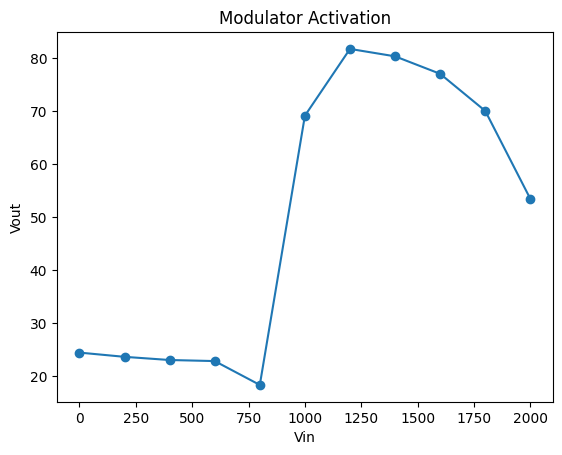

In [ ]:
import matplotlib.pyplot as plt

plt.plot(vin, vout, 'o-')
plt.xlabel("Vin")
plt.ylabel("Vout")
plt.title("Modulator Activation")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# If you don't have sklearn:
# !pip install scikit-learn
from sklearn.metrics import confusion_matrix

# ---------- Load your activation curve ----------
file_path = r"C:\Users\ghd1\Documents\AI-Photonics\modulator_activation.xlsx"
data = pd.read_excel(file_path)
data.columns = data.columns.astype(str).str.strip()  # remove hidden spaces

vin_np = data["Vin"].to_numpy(dtype=np.float32)
vout_np = data["Vout"].to_numpy(dtype=np.float32)

# Sort by Vin (important)
order = np.argsort(vin_np)
vin_np = vin_np[order]
vout_np = vout_np[order]

# Normalize Vout to 0..1 (recommended for stable training)
vout_min, vout_max = float(vout_np.min()), float(vout_np.max())
vout_np_norm = (vout_np - vout_min) / (vout_max - vout_min + 1e-12)

vin = torch.tensor(vin_np, dtype=torch.float32)
vout = torch.tensor(vout_np_norm, dtype=torch.float32)

# ---------- Custom activation module ----------
class MeasuredActivation(nn.Module):
    """
    Piecewise-linear interpolation y = f(x) using your measured (vin, vout) curve.
    """
    def __init__(self, vin: torch.Tensor, vout: torch.Tensor):
        super().__init__()
        self.register_buffer("vin", vin)
        self.register_buffer("vout", vout)

    def forward(self, x):
        # x: any shape
        x_flat = x.reshape(-1)

        # clamp to curve range
        x_flat = torch.clamp(x_flat, self.vin[0], self.vin[-1])

        # find segment indices
        idx = torch.bucketize(x_flat, self.vin)  # 0..len(vin)
        idx = torch.clamp(idx, 1, self.vin.numel()-1)

        x0 = self.vin[idx-1]
        x1 = self.vin[idx]
        y0 = self.vout[idx-1]
        y1 = self.vout[idx]

        # linear interpolation
        t = (x_flat - x0) / (x1 - x0 + 1e-12)
        y_flat = y0 + t * (y1 - y0)

        return y_flat.reshape(x.shape)

# ---------- MNIST data ----------
transform = transforms.ToTensor()
train_data = datasets.MNIST(".", train=True, download=True, transform=transform)
test_data  = datasets.MNIST(".", train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=256, shuffle=False)

# ---------- Build a network using your activation ----------
# IMPORTANT: your vin is 0..2000. MNIST features are ~0..1.
# So we scale internal pre-activation values into your vin range.
VIN_MIN = float(vin_np.min())
VIN_MAX = float(vin_np.max())
VIN_RANGE = VIN_MAX - VIN_MIN

class NetMeasuredAct(nn.Module):
    def __init__(self, vin, vout):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.act = MeasuredActivation(vin, vout)
        self.fc2 = nn.Linear(128, 10)

        # scale factor to map typical fc1 outputs into vin-range
        # you can tweak this if needed
        self.scale = 300.0   # try 100, 300, 800, etc.
        self.offset = (VIN_MIN + VIN_MAX) / 2.0

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)

        # map fc1 outputs -> Vin domain
        x = x * self.scale + self.offset

        # apply measured activation (gives 0..1)
        x = self.act(x)

        # continue
        x = self.fc2(x)
        return x

model = NetMeasuredAct(vin, vout)

# ---------- Train ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 3
model.train()
for epoch in range(EPOCHS):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{EPOCHS} done")


Epoch 1/3 done
Epoch 2/3 done
Epoch 3/3 done


Test accuracy: 96.48%
Prediction error rate: 3.52%
Confusion Matrix:
 [[ 967    0    0    1    0    2    8    1    1    0]
 [   0 1123    2    1    0    1    4    1    3    0]
 [   5    3  986    8    2    1    6    7   13    1]
 [   0    0    5  979    0    5    0   10    8    3]
 [   0    0    3    0  944    0   11    1    3   20]
 [   5    1    0   25    4  829   11    2   13    2]
 [   6    3    2    1    2    6  934    0    4    0]
 [   1    4   10    6    1    1    0  994    0   11]
 [   3    2    2   11    4    2    6    7  933    4]
 [   5    5    0    9   13    4    1    9    4  959]]


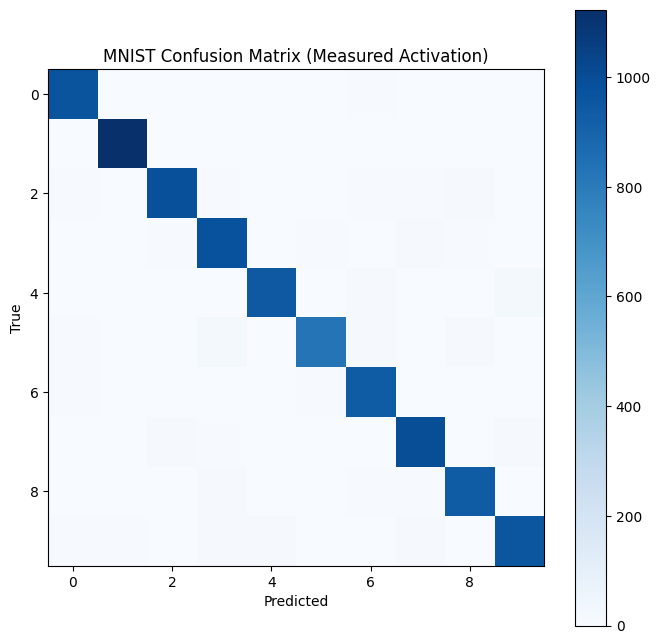

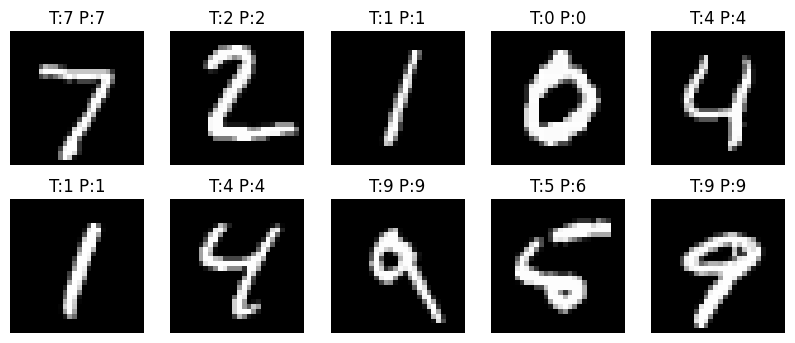

In [ ]:
model.eval()

all_preds = []
all_labels = []

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

acc = correct / total
err = 1 - acc
print(f"Test accuracy: {acc*100:.2f}%")
print(f"Prediction error rate: {err*100:.2f}%")

# Confusion matrix (numbers)
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Confusion matrix (plot)
plt.figure(figsize=(8,8))
plt.imshow(cm, cmap="Blues")
plt.title("MNIST Confusion Matrix (Measured Activation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

# Show 10 example predictions
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    preds = torch.argmax(model(images), dim=1)

plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i].cpu().squeeze(), cmap="gray")
    plt.title(f"T:{labels[i].item()} P:{preds[i].item()}")
    plt.axis("off")
plt.show()
